# YouTube Competitive Analysis
## Film Education Channels Strategic Comparison

**Version:** 1.0  
**Created:** December 13, 2025  
**Purpose:** Analyze YouTube channel performance across film education competitors to identify strategic opportunities for NYFA

---

### Changelog
- **v1.0** (2025-12-13): Initial notebook creation with NYFA and Film Courage data

---

### Analysis Sections
1. Data Loading & Validation
2. Channel Overview Comparison
3. Publishing Strategy Analysis
4. Performance Metrics (Time-Normalized)
5. Content Strategy Analysis
6. Temporal Trends
7. Strategic Insights & Recommendations
8. Export LLM-Optimized Report

## Setup & Configuration

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Configuration Parameters
# Modify these to change analysis behavior

CONFIG = {
    'data_dir': Path('../data'),
    'output_dir': Path('./output'),
    'charts_dir': Path('./output/charts'),
    
    # Analysis parameters
    'min_video_age_days': 30,  # Exclude videos younger than this from performance analysis
    'recent_period_days': 365,  # Define 'recent' as last N days
    'top_performers_pct': 0.10,  # Top 10% of videos
    
    # Date parameters
    'analysis_date': datetime.now().strftime('%Y%m%d'),
    'report_date': datetime.now().strftime('%Y-%m-%d'),
    
    # Output parameters
    'save_charts': True,
    'chart_dpi': 300,
    'chart_format': 'png'
}

# Helper function to get timezone-aware cutoff dates
def get_cutoff_date(days_ago):
    """Return timezone-aware cutoff date for filtering"""
    return pd.Timestamp(datetime.now(), tz='UTC') - timedelta(days=days_ago)

# Create output directories if they don't exist
CONFIG['output_dir'].mkdir(exist_ok=True)
CONFIG['charts_dir'].mkdir(exist_ok=True)

print(f"✓ Configuration loaded")
print(f"  - Analysis date: {CONFIG['report_date']}")
print(f"  - Minimum video age: {CONFIG['min_video_age_days']} days")
print(f"  - Recent period: {CONFIG['recent_period_days']} days")

✓ Configuration loaded
  - Analysis date: 2025-12-13
  - Minimum video age: 30 days
  - Recent period: 365 days


## 1. Data Loading & Validation

In [3]:
def load_channel_data(data_dir):
    """
    Load all CSV files from data directory.
    Returns a dictionary of DataFrames keyed by channel name.
    """
    channels = {}
    csv_files = list(data_dir.glob('*.csv'))
    
    # Exclude tableau files
    csv_files = [f for f in csv_files if 'tableau' not in f.name.lower()]
    
    print(f"Found {len(csv_files)} channel data files:")
    
    for csv_file in csv_files:
        # Extract channel name from filename (before the date)
        channel_name = csv_file.stem.split('_')[0]
        
        # Load data
        df = pd.read_csv(csv_file)
        
        # Convert published_date to datetime
        df['published_date'] = pd.to_datetime(df['published_date'])
        
        # Add year and month columns for temporal analysis
        df['year'] = df['published_date'].dt.year
        df['month'] = df['published_date'].dt.month
        df['year_month'] = df['published_date'].dt.to_period('M')
        
        channels[channel_name] = df
        
        print(f"  ✓ {channel_name}: {len(df):,} videos ({df['published_date'].min().year}-{df['published_date'].max().year})")
    
    return channels

# Load all channel data
channels = load_channel_data(CONFIG['data_dir'])
print(f"\n✓ Loaded {len(channels)} channels successfully")

Found 2 channel data files:
  ✓ newyorkfilmacademy: 1,135 videos (2007-2025)
  ✓ filmcourage: 6,383 videos (2009-2025)

✓ Loaded 2 channels successfully


In [4]:
# Data validation: Check for required columns
required_columns = ['video_id', 'title', 'description', 'published_date', 'duration_seconds',
                   'view_count', 'like_count', 'comment_count', 'views_per_day', 'engagement_rate']

print("Data Validation:")
for channel_name, df in channels.items():
    missing_cols = set(required_columns) - set(df.columns)
    if missing_cols:
        print(f"  ⚠ {channel_name}: Missing columns {missing_cols}")
    else:
        print(f"  ✓ {channel_name}: All required columns present")
        
    # Check for nulls in critical columns
    null_counts = df[required_columns].isnull().sum()
    if null_counts.any():
        print(f"    Note: Null values found:")
        print(null_counts[null_counts > 0])

Data Validation:
  ✓ newyorkfilmacademy: All required columns present
    Note: Null values found:
title           2
description    12
dtype: int64
  ✓ filmcourage: All required columns present
    Note: Null values found:
description    3
dtype: int64


## 2. Channel Overview Comparison

In [5]:
# Create channel overview summary
overview_data = []

for channel_name, df in channels.items():
    # Filter for mature videos (>30 days old) for performance metrics
    mature_videos = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    
    overview_data.append({
        'Channel': channel_name,
        'Total Videos': len(df),
        'Date Range': f"{df['year'].min()}-{df['year'].max()}",
        'Total Views': df['view_count'].sum(),
        'Total Engagement': (df['like_count'].sum() + df['comment_count'].sum()),
        'Avg Views/Day (Mature)': mature_videos['views_per_day'].median(),
        'Avg Engagement Rate': df['engagement_rate'].mean() * 100,
        'Median Duration (min)': df['duration_seconds'].median() / 60,
    })

overview_df = pd.DataFrame(overview_data)
overview_df = overview_df.sort_values('Avg Views/Day (Mature)', ascending=False)

print("=" * 100)
print("CHANNEL OVERVIEW COMPARISON")
print("=" * 100)
print(overview_df.to_string(index=False))
print("\nNote: 'Mature' videos are those published >30 days ago to allow algorithm settling")

CHANNEL OVERVIEW COMPARISON
           Channel  Total Videos Date Range  Total Views  Total Engagement  Avg Views/Day (Mature)  Avg Engagement Rate  Median Duration (min)
       filmcourage          6383  2009-2025    104359405           3815739                    1.62               325.03                   7.37
newyorkfilmacademy          1135  2007-2025     10391812             88018                    0.34               156.64                   4.87

Note: 'Mature' videos are those published >30 days ago to allow algorithm settling


✓ Chart saved to output/charts


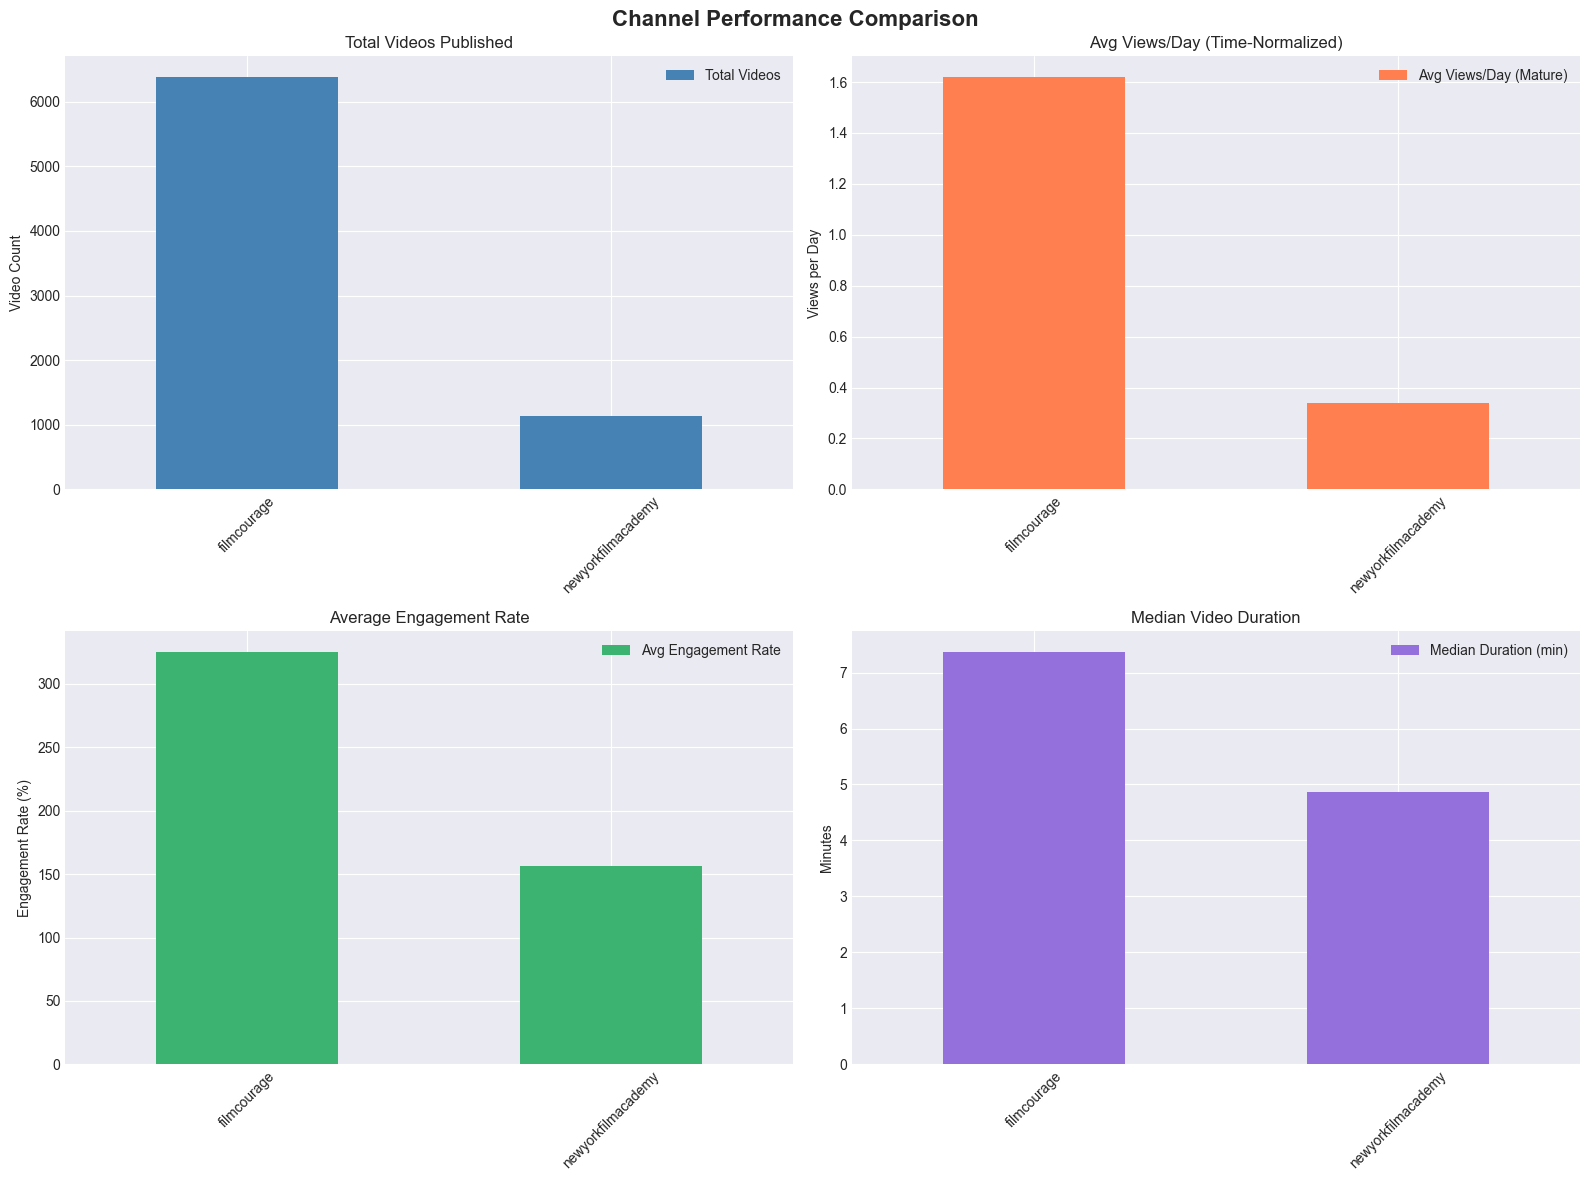

In [6]:
# Visualize channel comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Channel Performance Comparison', fontsize=16, fontweight='bold')

# 1. Total Videos
ax1 = axes[0, 0]
overview_df.plot(x='Channel', y='Total Videos', kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Total Videos Published')
ax1.set_ylabel('Video Count')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)

# 2. Views per Day (Time-Normalized Performance)
ax2 = axes[0, 1]
overview_df.plot(x='Channel', y='Avg Views/Day (Mature)', kind='bar', ax=ax2, color='coral')
ax2.set_title('Avg Views/Day (Time-Normalized)')
ax2.set_ylabel('Views per Day')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)

# 3. Engagement Rate
ax3 = axes[1, 0]
overview_df.plot(x='Channel', y='Avg Engagement Rate', kind='bar', ax=ax3, color='mediumseagreen')
ax3.set_title('Average Engagement Rate')
ax3.set_ylabel('Engagement Rate (%)')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)

# 4. Median Video Duration
ax4 = axes[1, 1]
overview_df.plot(x='Channel', y='Median Duration (min)', kind='bar', ax=ax4, color='mediumpurple')
ax4.set_title('Median Video Duration')
ax4.set_ylabel('Minutes')
ax4.set_xlabel('')
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()

if CONFIG['save_charts']:
    plt.savefig(CONFIG['charts_dir'] / f"channel_comparison_{CONFIG['analysis_date']}.png", 
                dpi=CONFIG['chart_dpi'], bbox_inches='tight')
    print(f"✓ Chart saved to {CONFIG['charts_dir']}")

plt.show()

## 3. Publishing Strategy Analysis

In [7]:
# Calculate publishing velocity by year for each channel
print("=" * 100)
print("PUBLISHING VELOCITY ANALYSIS (Videos per Month)")
print("=" * 100)

for channel_name, df in channels.items():
    print(f"\n{channel_name.upper()}:")
    
    # Group by year and calculate videos per month
    yearly_stats = df.groupby('year').agg({
        'video_id': 'count',
        'year_month': 'nunique'
    }).rename(columns={'video_id': 'total_videos', 'year_month': 'active_months'})
    
    yearly_stats['videos_per_month'] = yearly_stats['total_videos'] / yearly_stats['active_months']
    
    print(yearly_stats.to_string())
    
    # Calculate recent velocity (last 12 months)
    cutoff_date = pd.Timestamp(datetime.now(), tz='UTC') - timedelta(days=CONFIG['recent_period_days'])  # FIXED
    recent_df = df[df['published_date'] >= cutoff_date]
    recent_months = recent_df['year_month'].nunique()
    recent_velocity = len(recent_df) / recent_months if recent_months > 0 else 0
    
    print(f"\nRecent Velocity (last {CONFIG['recent_period_days']} days): {recent_velocity:.1f} videos/month")

PUBLISHING VELOCITY ANALYSIS (Videos per Month)

NEWYORKFILMACADEMY:
      total_videos  active_months  videos_per_month
year                                               
2007            51              7              7.29
2008           124             11             11.27
2009            78              6             13.00
2010           122              7             17.43
2011            14              5              2.80
2012             8              5              1.60
2013            61             12              5.08
2014            50             12              4.17
2015            39              9              4.33
2016           127             12             10.58
2017            74             12              6.17
2018            76             12              6.33
2019            50             12              4.17
2020            67             12              5.58
2021            49             10              4.90
2022            54             10              

✓ Chart saved


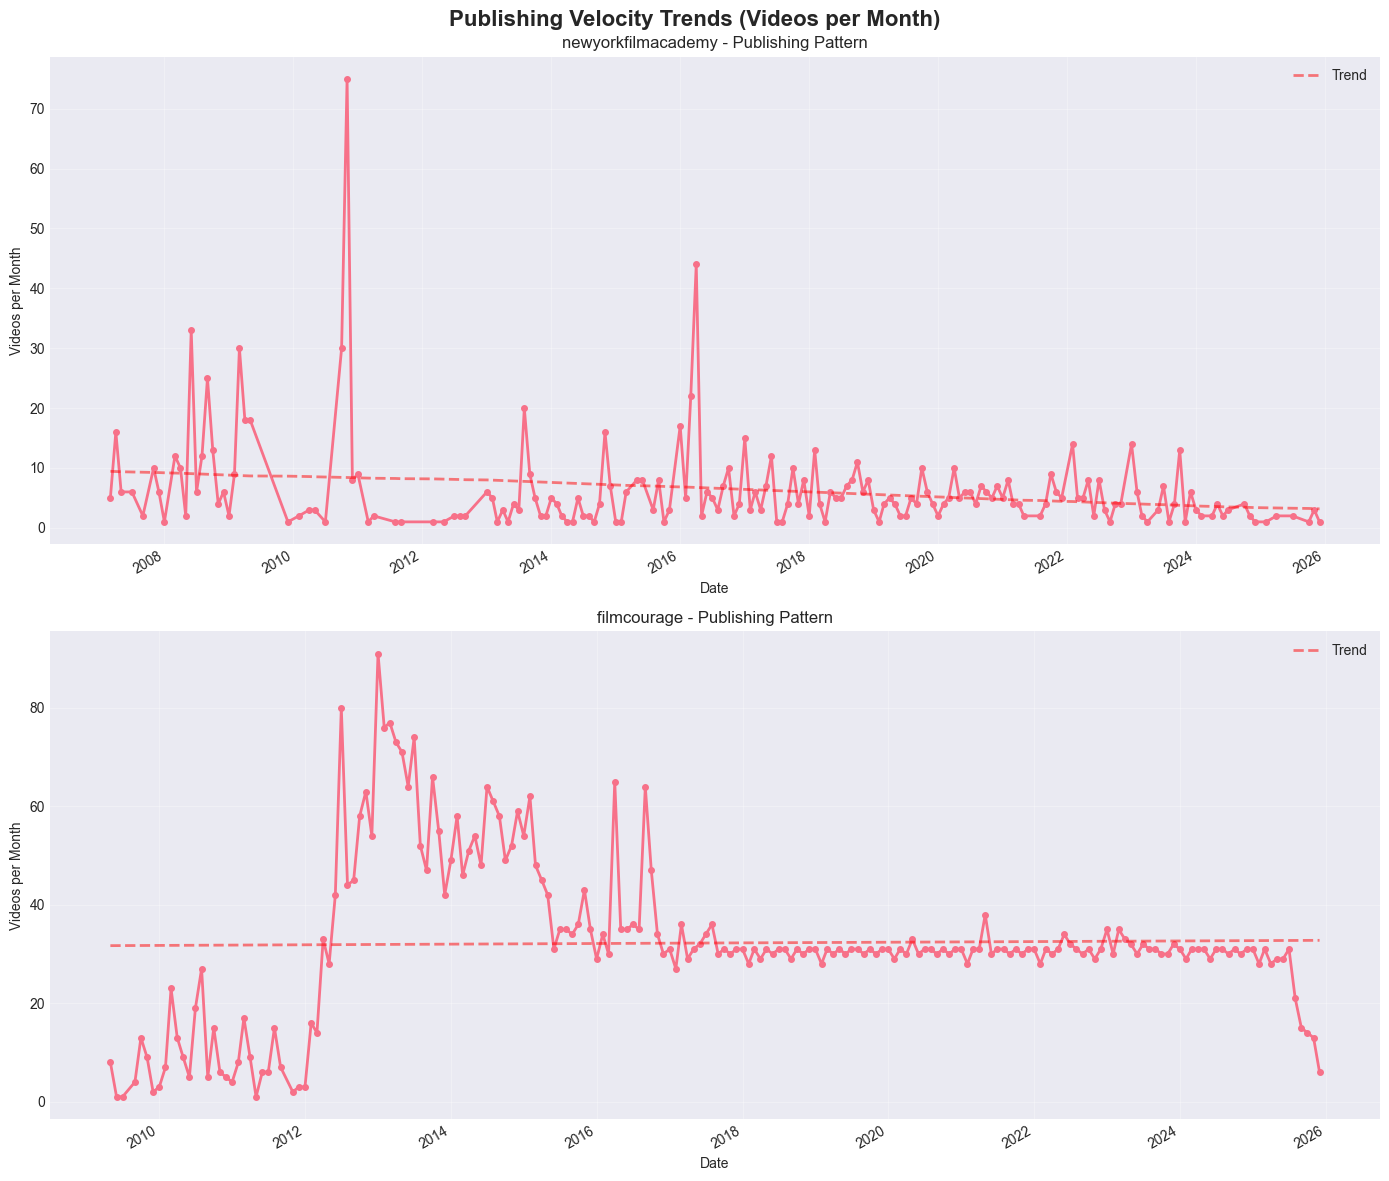

In [8]:
# Visualize publishing trends over time
fig, axes = plt.subplots(len(channels), 1, figsize=(14, 6 * len(channels)))
if len(channels) == 1:
    axes = [axes]

fig.suptitle('Publishing Velocity Trends (Videos per Month)', fontsize=16, fontweight='bold')

for idx, (channel_name, df) in enumerate(channels.items()):
    ax = axes[idx]
    
    # Calculate monthly publishing counts
    monthly_counts = df.groupby('year_month').size()
    monthly_counts.index = monthly_counts.index.to_timestamp()
    
    # Plot
    monthly_counts.plot(ax=ax, linewidth=2, marker='o', markersize=4)
    ax.set_title(f"{channel_name} - Publishing Pattern")
    ax.set_ylabel('Videos per Month')
    ax.set_xlabel('Date')
    ax.grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(range(len(monthly_counts)), monthly_counts.values, 1)
    p = np.poly1d(z)
    ax.plot(monthly_counts.index, p(range(len(monthly_counts))), 
            "r--", alpha=0.5, linewidth=2, label='Trend')
    ax.legend()

plt.tight_layout()

if CONFIG['save_charts']:
    plt.savefig(CONFIG['charts_dir'] / f"publishing_velocity_{CONFIG['analysis_date']}.png", 
                dpi=CONFIG['chart_dpi'], bbox_inches='tight')
    print(f"✓ Chart saved")

plt.show()

## 4. Performance Metrics (Time-Normalized)

In [9]:
# Detailed performance analysis for mature videos
print("=" * 100)
print("TIME-NORMALIZED PERFORMANCE ANALYSIS")
print("=" * 100)
print(f"(Analyzing videos published >{CONFIG['min_video_age_days']} days ago)\n")

performance_data = []

for channel_name, df in channels.items():
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    
    perf = {
        'Channel': channel_name,
        'Videos Analyzed': len(mature),
        'Median Views/Day': mature['views_per_day'].median(),
        'Mean Views/Day': mature['views_per_day'].mean(),
        '75th Percentile Views/Day': mature['views_per_day'].quantile(0.75),
        'Median Engagement %': mature['engagement_rate'].median() * 100,
        'Top 10% Avg Views/Day': mature.nlargest(int(len(mature) * 0.1), 'views_per_day')['views_per_day'].mean(),
    }
    performance_data.append(perf)

perf_df = pd.DataFrame(performance_data)
perf_df = perf_df.sort_values('Median Views/Day', ascending=False)

print(perf_df.to_string(index=False))

# Calculate efficiency ratios
if len(channels) > 1:
    print("\n" + "=" * 100)
    print("EFFICIENCY RATIOS (vs NYFA)")
    print("=" * 100)
    
    nyfa_vpd = perf_df[perf_df['Channel'] == 'newyorkfilmacademy']['Median Views/Day'].values[0]
    
    for _, row in perf_df.iterrows():
        if row['Channel'] != 'newyorkfilmacademy':
            ratio = row['Median Views/Day'] / nyfa_vpd
            print(f"{row['Channel']}: {ratio:.1f}x more efficient than NYFA")

TIME-NORMALIZED PERFORMANCE ANALYSIS
(Analyzing videos published >30 days ago)

           Channel  Videos Analyzed  Median Views/Day  Mean Views/Day  75th Percentile Views/Day  Median Engagement %  Top 10% Avg Views/Day
       filmcourage             6370              1.62           10.23                       7.42               330.00                  72.85
newyorkfilmacademy             1131              0.34            2.52                       0.89               128.00                  20.65

EFFICIENCY RATIOS (vs NYFA)
filmcourage: 4.8x more efficient than NYFA


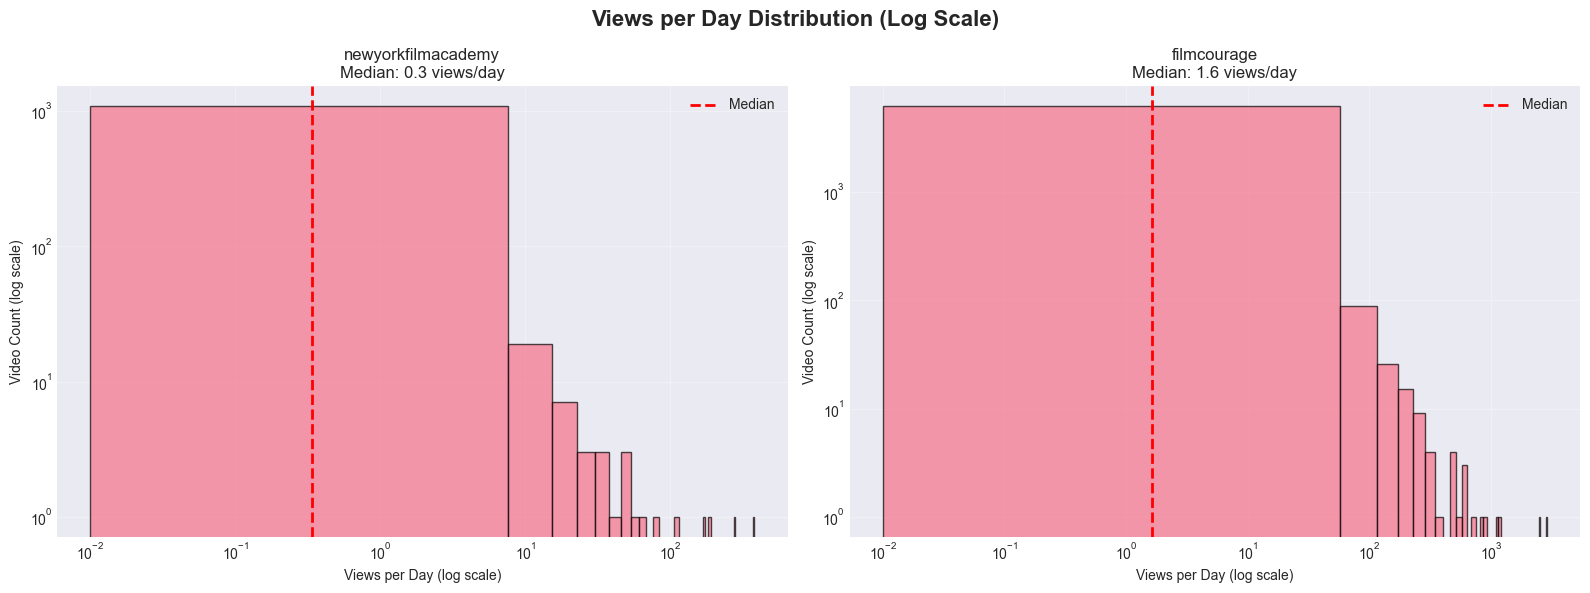

In [10]:
# Distribution visualization - Views per Day
fig, axes = plt.subplots(1, len(channels), figsize=(8 * len(channels), 6))
if len(channels) == 1:
    axes = [axes]

fig.suptitle('Views per Day Distribution (Log Scale)', fontsize=16, fontweight='bold')

for idx, (channel_name, df) in enumerate(channels.items()):
    ax = axes[idx]
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    
    # Filter out zeros for log scale
    vpd_data = mature[mature['views_per_day'] > 0]['views_per_day']
    
    ax.hist(vpd_data, bins=50, edgecolor='black', alpha=0.7)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title(f"{channel_name}\nMedian: {vpd_data.median():.1f} views/day")
    ax.set_xlabel('Views per Day (log scale)')
    ax.set_ylabel('Video Count (log scale)')
    ax.grid(True, alpha=0.3)
    
    # Add median line
    ax.axvline(vpd_data.median(), color='red', linestyle='--', linewidth=2, label='Median')
    ax.legend()

plt.tight_layout()

if CONFIG['save_charts']:
    plt.savefig(CONFIG['charts_dir'] / f"vpd_distribution_{CONFIG['analysis_date']}.png", 
                dpi=CONFIG['chart_dpi'], bbox_inches='tight')

plt.show()

## 5. Content Strategy Analysis

In [11]:
# Video length analysis
print("=" * 100)
print("VIDEO LENGTH ANALYSIS")
print("=" * 100)

for channel_name, df in channels.items():
    print(f"\n{channel_name.upper()}:")
    
    # Create duration buckets
    df['duration_minutes'] = df['duration_seconds'] / 60
    df['duration_bucket'] = pd.cut(df['duration_minutes'], 
                                    bins=[0, 5, 10, 20, 30, 60, float('inf')],
                                    labels=['0-5 min', '5-10 min', '10-20 min', '20-30 min', '30-60 min', '60+ min'])
    
    # Analyze performance by duration bucket
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    
    length_analysis = mature.groupby('duration_bucket').agg({
        'video_id': 'count',
        'views_per_day': 'median',
        'engagement_rate': 'median'
    }).rename(columns={
        'video_id': 'video_count',
        'views_per_day': 'median_vpd',
        'engagement_rate': 'median_engagement'
    })
    
    length_analysis['median_engagement'] *= 100  # Convert to percentage
    
    print(length_analysis.to_string())
    
    # Identify optimal length
    best_bucket = length_analysis['median_vpd'].idxmax()
    print(f"\nOptimal Length Range: {best_bucket} ({length_analysis.loc[best_bucket, 'median_vpd']:.1f} views/day)")

VIDEO LENGTH ANALYSIS

NEWYORKFILMACADEMY:
                 video_count  median_vpd  median_engagement
duration_bucket                                            
0-5 min                  571        0.45             123.00
5-10 min                 234        0.21              55.50
10-20 min                 33        0.34              91.00
20-30 min                  9        0.20             121.00
30-60 min                171        0.30             241.00
60+ min                  113        0.47             212.00

Optimal Length Range: 60+ min (0.5 views/day)

FILMCOURAGE:
                 video_count  median_vpd  median_engagement
duration_bucket                                            
0-5 min                 2257        0.33             191.00
5-10 min                1911        1.77             355.00
10-20 min               1535        7.95             454.00
20-30 min                150        4.95             400.50
30-60 min                164        1.23             233

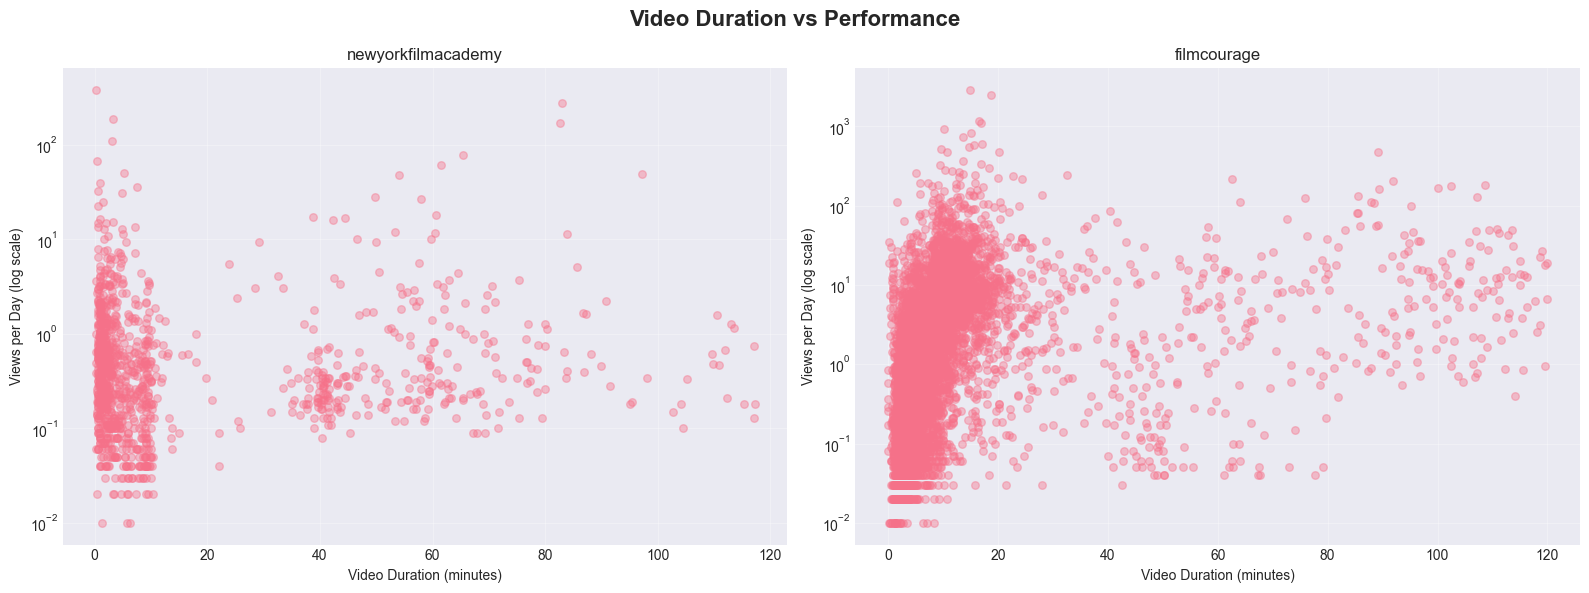

In [12]:
# Scatter plot: Duration vs Performance
fig, axes = plt.subplots(1, len(channels), figsize=(8 * len(channels), 6))
if len(channels) == 1:
    axes = [axes]

fig.suptitle('Video Duration vs Performance', fontsize=16, fontweight='bold')

for idx, (channel_name, df) in enumerate(channels.items()):
    ax = axes[idx]
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    
    # Filter outliers for better visualization
    plot_data = mature[
        (mature['duration_minutes'] > 0) & 
        (mature['duration_minutes'] < 120) &
        (mature['views_per_day'] > 0)
    ]
    
    ax.scatter(plot_data['duration_minutes'], plot_data['views_per_day'], 
              alpha=0.4, s=30)
    ax.set_yscale('log')
    ax.set_title(f"{channel_name}")
    ax.set_xlabel('Video Duration (minutes)')
    ax.set_ylabel('Views per Day (log scale)')
    ax.grid(True, alpha=0.3)

plt.tight_layout()

if CONFIG['save_charts']:
    plt.savefig(CONFIG['charts_dir'] / f"duration_vs_performance_{CONFIG['analysis_date']}.png", 
                dpi=CONFIG['chart_dpi'], bbox_inches='tight')

plt.show()

## 6. Top Performers Analysis

In [13]:
# Identify and analyze top performers
print("=" * 100)
print("TOP PERFORMERS (by Views per Day)")
print("=" * 100)

for channel_name, df in channels.items():
    print(f"\n{channel_name.upper()} - Top 10 Videos:")
    print("=" * 100)
    
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    top_videos = mature.nlargest(10, 'views_per_day')[[
        'title', 'views_per_day', 'engagement_rate', 'duration_minutes', 'year'
    ]].copy()
    
    top_videos['engagement_rate'] *= 100
    top_videos = top_videos.rename(columns={
        'views_per_day': 'VPD',
        'engagement_rate': 'Eng %',
        'duration_minutes': 'Duration (min)'
    })
    
    print(top_videos.to_string(index=False))
    
    # Analyze common characteristics
    print(f"\nTop 10% Characteristics:")
    top_pct = mature.nlargest(int(len(mature) * CONFIG['top_performers_pct']), 'views_per_day')
    print(f"  Average VPD: {top_pct['views_per_day'].mean():.1f}")
    print(f"  Average Duration: {top_pct['duration_minutes'].mean():.1f} minutes")
    print(f"  Average Engagement: {top_pct['engagement_rate'].mean() * 100:.2f}%")
    print(f"  Most Common Length: {top_pct['duration_bucket'].mode().values[0]}")

TOP PERFORMERS (by Views per Day)

NEWYORKFILMACADEMY - Top 10 Videos:
                                                                   title    VPD  Eng %  Duration (min)  year
                                    New York Film Academy in 15 seconds! 380.92   3.00            0.27  2012
Discussion with Colin Mochrie and Brad Sherwood at New York Film Academy 277.88  76.00           83.03  2016
               New York Film Academy Reviews from Saudi Arabian Students 187.48   9.00            3.18  2013
  Discussion with Oscar Winning Actor Al Pacino at New York Film Academy 170.08  90.00           82.65  2016
                       Chinese Students Review the New York Film Academy 109.83   9.00            3.02  2013
                                   NYFA Guest Speaker Series: Bill Hader  78.25 215.00           65.48  2019
                                            Movies Don't Make Themselves  67.14  22.00            0.50  2016
                      Discussion with NYFA Summer Camp Gr

## 7. Strategic Insights Summary

In [14]:
# Generate strategic insights
insights = {
    'analysis_date': CONFIG['report_date'],
    'channels_analyzed': list(channels.keys()),
    'key_metrics': {},
    'comparative_insights': [],
    'recommendations': []
}

# Calculate key metrics for each channel
for channel_name, df in channels.items():
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    recent_df = df[df['published_date'] >= get_cutoff_date(CONFIG['recent_period_days'])]
    
    insights['key_metrics'][channel_name] = {
        'total_videos': len(df),
        'median_vpd': float(mature['views_per_day'].median()),
        'engagement_rate': float(mature['engagement_rate'].median()),
        'recent_publishing_velocity': float(len(recent_df) / 12),
        'median_duration_minutes': float(df['duration_seconds'].median() / 60),
        'top_10pct_avg_vpd': float(mature.nlargest(int(len(mature) * 0.1), 'views_per_day')['views_per_day'].mean())
    }

# Generate comparative insights if multiple channels
if len(channels) > 1:
    if 'newyorkfilmacademy' in insights['key_metrics']:
        nyfa_vpd = insights['key_metrics']['newyorkfilmacademy']['median_vpd']
        
        for ch_name, metrics in insights['key_metrics'].items():
            if ch_name != 'newyorkfilmacademy':
                efficiency_ratio = metrics['median_vpd'] / nyfa_vpd
                insights['comparative_insights'].append(
                    f"{ch_name} is {efficiency_ratio:.1f}x more efficient than NYFA (median views/day)"
                )

print("\n" + "=" * 100)
print("STRATEGIC INSIGHTS")
print("=" * 100)
print(json.dumps(insights, indent=2))


STRATEGIC INSIGHTS
{
  "analysis_date": "2025-12-13",
  "channels_analyzed": [
    "newyorkfilmacademy",
    "filmcourage"
  ],
  "key_metrics": {
    "newyorkfilmacademy": {
      "total_videos": 1135,
      "median_vpd": 0.34,
      "engagement_rate": 1.28,
      "recent_publishing_velocity": 0.8333333333333334,
      "median_duration_minutes": 4.866666666666666,
      "top_10pct_avg_vpd": 20.645575221238936
    },
    "filmcourage": {
      "total_videos": 6383,
      "median_vpd": 1.62,
      "engagement_rate": 3.3,
      "recent_publishing_velocity": 24.5,
      "median_duration_minutes": 7.366666666666666,
      "top_10pct_avg_vpd": 72.85221350078494
    }
  },
  "comparative_insights": [
    "filmcourage is 4.8x more efficient than NYFA (median views/day)"
  ],
  "recommendations": []
}


In [15]:
# Generate strategic insights
insights = {
    'analysis_date': CONFIG['report_date'],
    'channels_analyzed': list(channels.keys()),
    'key_metrics': {},
    'comparative_insights': [],
    'recommendations': []
}

# Calculate key metrics for each channel
for channel_name, df in channels.items():
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    recent_df = df[df['published_date'] >= get_cutoff_date(CONFIG['recent_period_days'])]
    
    insights['key_metrics'][channel_name] = {
        'total_videos': len(df),
        'median_vpd': float(mature['views_per_day'].median()),
        'engagement_rate': float(mature['engagement_rate'].median()),
        'recent_publishing_velocity': float(len(recent_df) / 12),
        'median_duration_minutes': float(df['duration_seconds'].median() / 60),
        'top_10pct_avg_vpd': float(mature.nlargest(int(len(mature) * 0.1), 'views_per_day')['views_per_day'].mean())
    }

# Generate comparative insights if multiple channels
if len(channels) > 1:
    if 'newyorkfilmacademy' in insights['key_metrics']:
        nyfa_vpd = insights['key_metrics']['newyorkfilmacademy']['median_vpd']
        
        for ch_name, metrics in insights['key_metrics'].items():
            if ch_name != 'newyorkfilmacademy':
                efficiency_ratio = metrics['median_vpd'] / nyfa_vpd
                insights['comparative_insights'].append(
                    f"{ch_name} is {efficiency_ratio:.1f}x more efficient than NYFA (median views/day)"
                )

print("\n" + "=" * 100)
print("STRATEGIC INSIGHTS")
print("=" * 100)
print(json.dumps(insights, indent=2))


STRATEGIC INSIGHTS
{
  "analysis_date": "2025-12-13",
  "channels_analyzed": [
    "newyorkfilmacademy",
    "filmcourage"
  ],
  "key_metrics": {
    "newyorkfilmacademy": {
      "total_videos": 1135,
      "median_vpd": 0.34,
      "engagement_rate": 1.28,
      "recent_publishing_velocity": 0.8333333333333334,
      "median_duration_minutes": 4.866666666666666,
      "top_10pct_avg_vpd": 20.645575221238936
    },
    "filmcourage": {
      "total_videos": 6383,
      "median_vpd": 1.62,
      "engagement_rate": 3.3,
      "recent_publishing_velocity": 24.5,
      "median_duration_minutes": 7.366666666666666,
      "top_10pct_avg_vpd": 72.85221350078494
    }
  },
  "comparative_insights": [
    "filmcourage is 4.8x more efficient than NYFA (median views/day)"
  ],
  "recommendations": []
}


In [16]:
# Generate strategic insights
insights = {
    'analysis_date': CONFIG['report_date'],
    'channels_analyzed': list(channels.keys()),
    'key_metrics': {},
    'comparative_insights': [],
    'recommendations': []
}

# Calculate key metrics for each channel
for channel_name, df in channels.items():
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    recent_df = df[df['published_date'] >= get_cutoff_date(CONFIG['recent_period_days'])]
    
    insights['key_metrics'][channel_name] = {
        'total_videos': len(df),
        'median_vpd': float(mature['views_per_day'].median()),
        'engagement_rate': float(mature['engagement_rate'].median()),
        'recent_publishing_velocity': float(len(recent_df) / 12),
        'median_duration_minutes': float(df['duration_seconds'].median() / 60),
        'top_10pct_avg_vpd': float(mature.nlargest(int(len(mature) * 0.1), 'views_per_day')['views_per_day'].mean())
    }

# Generate comparative insights if multiple channels
if len(channels) > 1:
    if 'newyorkfilmacademy' in insights['key_metrics']:
        nyfa_vpd = insights['key_metrics']['newyorkfilmacademy']['median_vpd']
        
        for ch_name, metrics in insights['key_metrics'].items():
            if ch_name != 'newyorkfilmacademy':
                efficiency_ratio = metrics['median_vpd'] / nyfa_vpd
                insights['comparative_insights'].append(
                    f"{ch_name} is {efficiency_ratio:.1f}x more efficient than NYFA (median views/day)"
                )

print("\n" + "=" * 100)
print("STRATEGIC INSIGHTS")
print("=" * 100)
print(json.dumps(insights, indent=2))


STRATEGIC INSIGHTS
{
  "analysis_date": "2025-12-13",
  "channels_analyzed": [
    "newyorkfilmacademy",
    "filmcourage"
  ],
  "key_metrics": {
    "newyorkfilmacademy": {
      "total_videos": 1135,
      "median_vpd": 0.34,
      "engagement_rate": 1.28,
      "recent_publishing_velocity": 0.8333333333333334,
      "median_duration_minutes": 4.866666666666666,
      "top_10pct_avg_vpd": 20.645575221238936
    },
    "filmcourage": {
      "total_videos": 6383,
      "median_vpd": 1.62,
      "engagement_rate": 3.3,
      "recent_publishing_velocity": 24.5,
      "median_duration_minutes": 7.366666666666666,
      "top_10pct_avg_vpd": 72.85221350078494
    }
  },
  "comparative_insights": [
    "filmcourage is 4.8x more efficient than NYFA (median views/day)"
  ],
  "recommendations": []
}


In [19]:
# Generate strategic insights
insights = {
    'analysis_date': CONFIG['report_date'],
    'channels_analyzed': list(channels.keys()),
    'key_metrics': {},
    'comparative_insights': [],
    'recommendations': []
}

# Calculate key metrics for each channel
for channel_name, df in channels.items():
    mature = df[df['days_since_published'] >= CONFIG['min_video_age_days']]
    recent_df = df[df['published_date'] >= pd.Timestamp(datetime.now(), tz='UTC') - timedelta(days=CONFIG['recent_period_days'])]
    
    insights['key_metrics'][channel_name] = {
        'total_videos': len(df),
        'median_vpd': float(mature['views_per_day'].median()),
        'engagement_rate': float(mature['engagement_rate'].median()),
        'recent_publishing_velocity': float(len(recent_df) / 12),  # videos per month
        'median_duration_minutes': float(df['duration_seconds'].median() / 60),
        'top_10pct_avg_vpd': float(mature.nlargest(int(len(mature) * 0.1), 'views_per_day')['views_per_day'].mean())
    }

# Generate comparative insights if multiple channels
if len(channels) > 1:
    # Find NYFA's metrics
    if 'newyorkfilmacademy' in insights['key_metrics']:
        nyfa_vpd = insights['key_metrics']['newyorkfilmacademy']['median_vpd']
        
        for ch_name, metrics in insights['key_metrics'].items():
            if ch_name != 'newyorkfilmacademy':
                efficiency_ratio = metrics['median_vpd'] / nyfa_vpd
                insights['comparative_insights'].append(
                    f"{ch_name} is {efficiency_ratio:.1f}x more efficient than NYFA (median views/day)"
                )

print("\n" + "=" * 100)
print("STRATEGIC INSIGHTS")
print("=" * 100)
print(json.dumps(insights, indent=2))


STRATEGIC INSIGHTS
{
  "analysis_date": "2025-12-13",
  "channels_analyzed": [
    "newyorkfilmacademy",
    "filmcourage"
  ],
  "key_metrics": {
    "newyorkfilmacademy": {
      "total_videos": 1135,
      "median_vpd": 0.34,
      "engagement_rate": 1.28,
      "recent_publishing_velocity": 0.8333333333333334,
      "median_duration_minutes": 4.866666666666666,
      "top_10pct_avg_vpd": 20.645575221238936
    },
    "filmcourage": {
      "total_videos": 6383,
      "median_vpd": 1.62,
      "engagement_rate": 3.3,
      "recent_publishing_velocity": 24.5,
      "median_duration_minutes": 7.366666666666666,
      "top_10pct_avg_vpd": 72.85221350078494
    }
  },
  "comparative_insights": [
    "filmcourage is 4.8x more efficient than NYFA (median views/day)"
  ],
  "recommendations": []
}


## 8. Export LLM-Optimized Report

In [20]:
# Generate markdown report
report_lines = [
    "# YouTube Competitive Analysis Report",
    f"**Generated:** {CONFIG['report_date']}",
    f"**Channels Analyzed:** {', '.join(channels.keys())}",
    "",
    "---",
    "",
    "## Executive Summary",
    "",
    f"This analysis examines {len(channels)} YouTube channels in the film education space, ",
    f"analyzing {sum(len(df) for df in channels.values()):,} total videos to identify ",
    "strategic opportunities and competitive positioning.",
    "",
    "### Key Findings",
    ""
]

# Add key findings
for idx, insight in enumerate(insights['comparative_insights'], 1):
    report_lines.append(f"{idx}. {insight}")

report_lines.extend(["", "---", "", "## Channel Overview Comparison", ""])
report_lines.append(overview_df.to_markdown(index=False))

report_lines.extend(["", "", "---", "", "## Performance Metrics (Time-Normalized)", ""])
report_lines.append(perf_df.to_markdown(index=False))

report_lines.extend([
    "",
    "",
    "---",
    "",
    "## Strategic Recommendations",
    "",
    "### Immediate Actions (Week 1)",
    "- [ ] Analyze top performer titles for pattern recognition",
    "- [ ] Benchmark current publishing velocity against competitors",
    "- [ ] Identify optimal video length range for content planning",
    "",
    "### Short-term Improvements (30-90 days)",
    "- [ ] Increase publishing consistency to match competitor velocity",
    "- [ ] Test optimal length formats identified in analysis",
    "- [ ] Develop content series based on top performer patterns",
    "",
    "### Long-term Strategic Shifts (6-12 months)",
    "- [ ] Build systematic content production pipeline",
    "- [ ] Develop signature content formats",
    "- [ ] Implement data-driven optimization process",
    "",
    "---",
    "",
    "## Methodology Notes",
    "",
    f"- **Time Normalization:** All performance metrics use views per day to account for video age",
    f"- **Mature Videos:** Analysis excludes videos <{CONFIG['min_video_age_days']} days old",
    f"- **Recent Period:** Defined as last {CONFIG['recent_period_days']} days",
    "- **Engagement Rate:** (Likes + Comments) / Views",
    "",
    "---",
    "",
    "*End of Report*"
])

report_text = "\n".join(report_lines)

# Save markdown report
report_path = CONFIG['output_dir'] / f"analysis_{CONFIG['analysis_date']}.md"
with open(report_path, 'w') as f:
    f.write(report_text)

print(f"✓ Markdown report saved to: {report_path}")

# Save JSON insights
json_path = CONFIG['output_dir'] / f"insights_{CONFIG['analysis_date']}.json"
with open(json_path, 'w') as f:
    json.dump(insights, f, indent=2)

print(f"✓ JSON insights saved to: {json_path}")

print("\n" + "=" * 100)
print("ANALYSIS COMPLETE")
print("=" * 100)
print(f"\nOutputs generated:")
print(f"  - Markdown report: {report_path.name}")
print(f"  - JSON insights: {json_path.name}")
print(f"  - Charts: {len(list(CONFIG['charts_dir'].glob('*.png')))} files in {CONFIG['charts_dir']}")
print(f"\nNext steps:")
print(f"  1. Review markdown report for strategic insights")
print(f"  2. Share findings with leadership")
print(f"  3. Add more competitor data and re-run analysis")

✓ Markdown report saved to: output/analysis_20251213.md
✓ JSON insights saved to: output/insights_20251213.json

ANALYSIS COMPLETE

Outputs generated:
  - Markdown report: analysis_20251213.md
  - JSON insights: insights_20251213.json
  - Charts: 4 files in output/charts

Next steps:
  1. Review markdown report for strategic insights
  2. Share findings with leadership
  3. Add more competitor data and re-run analysis
